In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer , TfidfTransformer
from keras.models import Model
from keras.layers import LSTM , Activation , Dense , Dropout , Input , Embedding , SpatialDropout1D
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping , ModelCheckpoint
from keras.models import Sequential
from keras.utils import pad_sequences
from sklearn.metrics import confusion_matrix


pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth',255)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')           # Mount drive to acces uploaded csv file .




Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/labeled_data.csv')

In [4]:
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


In [5]:
data.drop(columns=['Unnamed: 0',	'count',	'hate_speech',	'offensive_language',	'neither'] , axis=1 , inplace=True)

In [6]:
data.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


<Axes: xlabel='class', ylabel='count'>

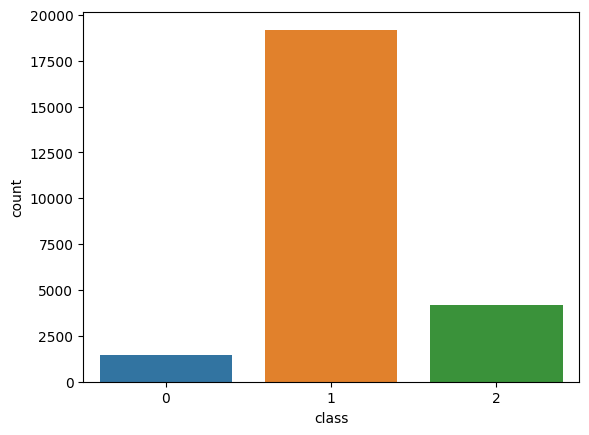

In [7]:
sns.countplot(x='class',data=data)


In [8]:
data['class'].replace({0:1},inplace=True)

<Axes: xlabel='class', ylabel='count'>

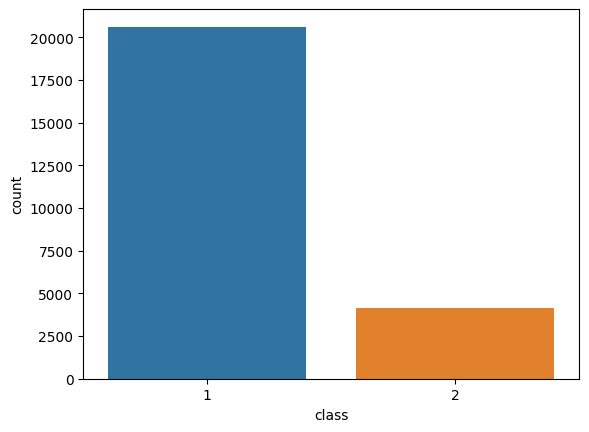

In [9]:
sns.countplot(x='class',data=data)

In [10]:
data['class'].replace({2:0},inplace=True)

<Axes: xlabel='class', ylabel='count'>

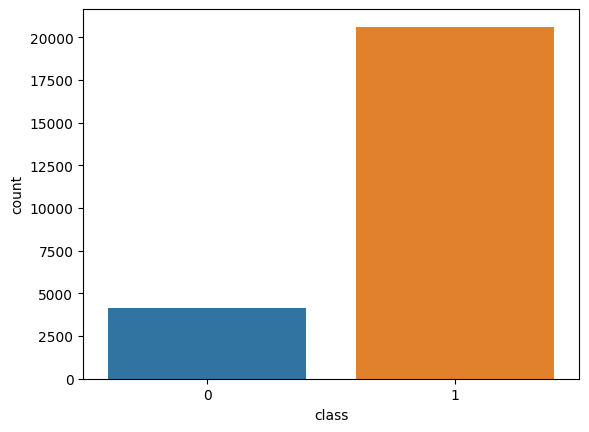

In [11]:
sns.countplot(x='class',data=data)

In [12]:
df = data.copy()

In [13]:
df.head()

,class,tweet
0,0,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


In [14]:
stemmer = nltk.SnowballStemmer('english')
stopword = set(stopwords.words('english'))

In [15]:
def data_cleaning(words):
    words = str(words).lower()
    words = re.sub('\[.*?\]', '', words)
    words = re.sub('https?://\S+|www\.\S+', '', words)
    words = re.sub('<.*?>+', '', words)
    words = re.sub('[%s]' % re.escape(string.punctuation), '', words)
    words = re.sub('\n', '', words)
    words = re.sub('\w*\d\w*', '', words)
    words = [word for word in words.split(' ') if words not in stopword]
    words=" ".join(words)
    words = [stemmer.stem(words) for word in words.split(' ')]
    words=" ".join(words)

    return words


In [16]:
df['tweet'] = df['tweet'].apply(data_cleaning)

In [17]:
df.head()

,class,tweet
0,0,rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the tra...
1,1,rt boy dats coldtyga dwn bad for cuffin dat hoe in the plac rt boy dats coldtyga dwn bad for cuffin dat hoe in the plac rt boy dats coldtyga dwn bad for cuffin dat hoe in the plac rt boy dats coldtyga dwn bad for cuffin dat hoe in the plac...
2,1,rt urkindofbrand dawg rt you ever fuck a bitch and she start to cry you be confused as shit rt urkindofbrand dawg rt you ever fuck a bitch and she start to cry you be confused as shit rt urkindofbrand dawg rt you ever fuck a bitch and she start ...
3,1,rt cganderson vivabased she look like a tranni rt cganderson vivabased she look like a tranni rt cganderson vivabased she look like a tranni rt cganderson vivabased she look like a tranni rt cganderson vivabased she look like a tranni rt cgander...
4,1,rt shenikaroberts the shit you hear about me might be true or it might be faker than the bitch who told it to ya rt shenikaroberts the shit you hear about me might be true or it might be faker than the bitch who told it to ya rt shenikaroberts th...


In [18]:
y = df['class']
x = df['tweet']


In [19]:

x_train , x_test , y_train , y_test = train_test_split(x,y,random_state=42,stratify=y)

In [20]:
len(x_train) , len(y_train) , len(x_test) , len(y_test)

(18587, 18587, 6196, 6196)

In [21]:
max_words = 50000
max_len = 300
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)


In [22]:
sequences_matrix = pad_sequences(sequences,maxlen=max_len)


In [23]:
model = Sequential()
model.add(Embedding(max_words , 100 , input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100,dropout=0.2,recurrent_dropout =0.2))
model.add(Dense(1,activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          5000000   
                                                                 
 spatial_dropout1d (Spatial  (None, 300, 100)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 5080501 (19.38 MB)
Trainable params: 5080501 (19.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
history = model.fit(sequences_matrix,y_train,batch_size=128,epochs = 1,
                   validation_split=0.2)

117/117 [==============================] - 164s 1s/step - loss: 0.3033 - accuracy: 0.8838 - val_loss: 0.1777 - val_accuracy: 0.9330


In [25]:
test_sequences = tokenizer.texts_to_sequences(x_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [26]:
# Model evaluation
accr = model.evaluate(test_sequences_matrix,y_test)

194/194 [==============================] - 16s 83ms/step - loss: 0.1922 - accuracy: 0.9306


In [27]:
lstm_prediction = model.predict(test_sequences_matrix)

194/194 [==============================] - 16s 82ms/step


In [28]:
res = []
for prediction in lstm_prediction:
    if prediction[0] < 0.5:
        res.append(0)
    else:
        res.append(1)

In [29]:
print(confusion_matrix(y_test,res))

[[ 758  283]
 [ 147 5008]]


In [30]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [31]:
# Let's save the mdoel.
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
import keras

In [33]:
load_model=keras.models.load_model("model.h5")
with open('tokenizer.pickle', 'rb') as handle:
    load_tokenizer = pickle.load(handle)

In [34]:
# Let's test our model on custom data.
test = 'humans are idiots'
def clean_text(text):
    print(text)
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    print(text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text
test=[clean_text(test)]
print(test)
seq = load_tokenizer.texts_to_sequences(test)
padded = pad_sequences(seq, maxlen=300)
print(seq)
pred = load_model.predict(padded)
print("pred", pred)
if pred<0.5:
    print("no hate")
else:
    print("hate and abusive")

humans are idiots
humans are idiots
['human idiot']
[[1146, 1658]]
1/1 [==============================] - 0s 446ms/step
pred [[0.719952]]
hate and abusive
